In [1]:
import pandas as pd
import glob
import pickle
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
import numpy as np
from numpy import cov
import seaborn as sns
import csv
#извлекает функцию из другого файла ipynb
#from ipynb.fs.full.Methods import download_ats_peak_load

## 1. Формирование фрейма исходных данных

In [2]:
df = pd.read_excel('INITIAL_DATA/Свод_Почасовая выработка 2019 и 2020 обновл.xls',sheet_name=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], usecols="A:E", skiprows=1,nrows=750, header = None, names = ['timestamp','Solar_generation','External_grid','Total_consumption', 'PVSyst' ])

In [3]:
cdf = pd.concat(df,axis=0, join="inner", ignore_index=True, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

In [4]:
cdf=cdf.dropna(subset=['timestamp', 'External_grid'])
cdf = pd.DataFrame(cdf) 
cdf.set_index('timestamp', inplace=True) # set column 'date' to index

In [5]:
cdf.head(10)

,Solar_generation,External_grid,Total_consumption,PVSyst
timestamp,,,,
2019-06-01 00:00:00,0.000000,271.349396,271.349396,0.00000
2019-06-01 01:00:00,0.000000,243.497849,243.497849,0.00000
2019-06-01 02:00:00,0.000000,258.530853,258.530853,0.00000
2019-06-01 03:00:00,0.000000,255.911179,255.911179,0.00000
2019-06-01 04:00:00,0.000000,257.222229,257.222229,0.00000
2019-06-01 05:00:00,0.275841,260.294891,260.570709,0.00000
2019-06-01 06:00:00,14.505750,233.185471,247.691208,11.81611
2019-06-01 07:00:00,50.503605,193.508102,244.011703,54.20180
2019-06-01 08:00:00,100.483910,198.510956,298.994873,124.11890


In [6]:
cdf.describe()

,Solar_generation,External_grid,Total_consumption,PVSyst
count,13143.000000,13143.000000,13136.000000,13142.000000
mean,31.876580,156.525587,188.417357,69.952133
std,66.501208,142.678545,172.222914,100.775985
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,56.182621,58.468653,0.000000
50%,1.463306,85.453865,107.195679,0.000000
75%,26.580052,265.544342,322.942841,124.118900
max,356.581116,940.887451,1075.956665,405.421449


## 2. Загрузка ЧПН

In [7]:
# specifying the path to csv files
path = "INITIAL_DATA/Peak_hours_fact/"
# xlsx files in the path
file_list = glob.glob(path + "/*.xls")
print(file_list)

['INITIAL_DATA/Peak_hours_fact\\201906_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\201907_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\201908_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\201909_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\201910_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\201911_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\201912_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202001_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202002_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202003_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202004_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202005_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202006_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\202007_KUBANESK_03_calcfacthour.xls', 'INITIAL_DATA/Peak_hours_fact\\20

In [8]:
excl_list = []
for file in file_list:
    df = pd.read_excel(file, usecols="A:B", skiprows=7,nrows=25, names = ['timestamp','Peak_hour'], parse_dates=True)
    df = pd.DataFrame(df) #преобразование в датафрейм
    df["timestamp"]=pd.to_datetime(df["timestamp"],format='%d.%m.%Y').dt.date
    df["Peak_hour"]=pd.to_datetime(df["Peak_hour"], format='%H').dt.time
    df["Peak_hour"]=pd.to_datetime(df["timestamp"].astype(str) + ' ' + df["Peak_hour"].astype(str))
    df_changed=df #создание нового датафрейма
    df_changed.drop(['timestamp'], inplace=True, axis=1) #убрать колонки Date and Time
    df_changed["Peak_hours"]=1
    excl_list.append(df_changed)#добавляем новый элементв в конец
excl_merged = pd.concat(excl_list, axis=0, ignore_index=False) #конкатенация всех листов
excl_merged.columns = ['timestamp','Peak_hour']
excl_merged.set_index('timestamp', inplace=True) # set column 'date' to index
#excl_merged.sort_values(by='timestamp', inplace=True) #сортировка по timeseries в порядке возрастания
#excl_merged.set_index('timestamp', inplace=True) # set column 'date' to index
excl_merged

,Peak_hour
timestamp,
2019-06-03 16:00:00,1
2019-06-04 15:00:00,1
2019-06-05 15:00:00,1
2019-06-06 16:00:00,1
2019-06-07 14:00:00,1
...,...
2020-12-25 19:00:00,1
2020-12-28 19:00:00,1
2020-12-29 19:00:00,1


In [9]:
dt=pd.merge(cdf,excl_merged,how = 'left', on='timestamp')
dt['Peak_hour'] = dt['Peak_hour'].fillna(0)
dt['year'] = dt.index.year
dt['month'] = dt.index.month
dt['day'] =  dt.index.day
dt['hour'] =  dt.index.hour
dt.head(1000)

,Solar_generation,External_grid,Total_consumption,PVSyst,Peak_hour,year,month,day,hour
timestamp,,,,,,,,,
2019-06-01 00:00:00,0.000000,271.349396,271.349396,0.0000,0.0,2019,6,1,0
2019-06-01 01:00:00,0.000000,243.497849,243.497849,0.0000,0.0,2019,6,1,1
2019-06-01 02:00:00,0.000000,258.530853,258.530853,0.0000,0.0,2019,6,1,2
2019-06-01 03:00:00,0.000000,255.911179,255.911179,0.0000,0.0,2019,6,1,3
2019-06-01 04:00:00,0.000000,257.222229,257.222229,0.0000,0.0,2019,6,1,4
...,...,...,...,...,...,...,...,...,...
2019-07-12 10:00:00,102.766884,147.413116,250.180008,255.1839,0.0,2019,7,12,10
2019-07-12 11:00:00,261.742096,190.666122,452.408203,309.0271,0.0,2019,7,12,11
2019-07-12 12:00:00,327.202911,123.358971,450.561890,339.7674,0.0,2019,7,12,12


## 3. Загрузка ПЧПН

In [10]:
#июнь 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 6) & (dt['hour'] >= 8) & (dt['hour'] <= 16), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2019) & (dt['month'] == 6) & (dt['hour'] >= 20) & (dt['hour'] <= 21), 'planned_hour'] = 1 
#июль 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 7) & (dt['hour'] >= 8) & (dt['hour'] <= 17), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2019) & (dt['month'] == 7) & (dt['hour'] >= 20) & (dt['hour'] <= 21), 'planned_hour'] = 1
#август 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 8) & (dt['hour'] >= 8) & (dt['hour'] <= 21), 'planned_hour'] = 1
#сентябрь 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 9) & (dt['hour'] >= 8) & (dt['hour'] <= 15), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2019) & (dt['month'] == 9) & (dt['hour'] >= 18) & (dt['hour'] <= 21), 'planned_hour'] = 1
#октябрь 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 10) & (dt['hour'] >= 8) & (dt['hour'] <= 21), 'planned_hour'] = 1
#ноябрь 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 11) & (dt['hour'] >= 8) & (dt['hour'] <= 11), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2019) & (dt['month'] == 11) & (dt['hour'] >= 16) & (dt['hour'] <= 21), 'planned_hour'] = 1
#декабрь 2019
dt.loc[(dt['year'] == 2019) & (dt['month'] == 12) & (dt['hour'] >= 8) & (dt['hour'] <= 12), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2019) & (dt['month'] == 12) & (dt['hour'] >= 15) & (dt['hour'] <= 21), 'planned_hour'] = 1
#январь 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 1) & (dt['hour'] >= 8) & (dt['hour'] <= 21), 'planned_hour'] = 1
#февраль 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 2) & (dt['hour'] >= 8) & (dt['hour'] <= 13), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 2) & (dt['hour'] >= 17) & (dt['hour'] <= 21), 'planned_hour'] = 1
#март 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 3) & (dt['hour'] >= 8) & (dt['hour'] <= 21), 'planned_hour'] = 1
#апрель 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 4) & (dt['hour'] >= 8) & (dt['hour'] <= 15), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 4) & (dt['hour'] >= 18) & (dt['hour'] <= 21), 'planned_hour'] = 1
#май 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 5) & (dt['hour'] >= 8) & (dt['hour'] <= 15), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 5) & (dt['hour'] >= 20) & (dt['hour'] <= 21), 'planned_hour'] = 1
#июнь 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 6) & (dt['hour'] >= 8) & (dt['hour'] <= 16), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 6) & (dt['hour'] >= 20) & (dt['hour'] <= 21), 'planned_hour'] = 1
#июль 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 7) & (dt['hour'] >= 8) & (dt['hour'] <= 17), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 7) & (dt['hour'] >= 20) & (dt['hour'] <= 21), 'planned_hour'] = 1
#август 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 8) & (dt['hour'] >= 8) & (dt['hour'] <= 21), 'planned_hour'] = 1
#сентябрь 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 9) & (dt['hour'] >= 8) & (dt['hour'] <= 15), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 9) & (dt['hour'] >= 18) & (dt['hour'] <= 21), 'planned_hour'] = 1
#октябрь 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 10) & (dt['hour'] >= 8) & (dt['hour'] <= 21), 'planned_hour'] = 1
#ноябрь 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 11) & (dt['hour'] >= 8) & (dt['hour'] <= 11), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 11) & (dt['hour'] >= 16) & (dt['hour'] <= 21), 'planned_hour'] = 1
#декабрь 2020
dt.loc[(dt['year'] == 2020) & (dt['month'] == 12) & (dt['hour'] >= 8) & (dt['hour'] <= 12), 'planned_hour'] = 1
dt.loc[(dt['year'] == 2020) & (dt['month'] == 12) & (dt['hour'] >= 15) & (dt['hour'] <= 21), 'planned_hour'] = 1

dt['planned_hour'] = dt['planned_hour'].fillna(0)

In [38]:
dt.head(20)

,Solar_generation,External_grid,Total_consumption,PVSyst,Peak_hour,year,month,day,hour,planned_hour
timestamp,,,,,,,,,,
2019-06-01 00:00:00,0.000000,271.349396,271.349396,0.00000,0.0,2019,6,1,0,0.0
2019-06-01 01:00:00,0.000000,243.497849,243.497849,0.00000,0.0,2019,6,1,1,0.0
2019-06-01 02:00:00,0.000000,258.530853,258.530853,0.00000,0.0,2019,6,1,2,0.0
2019-06-01 03:00:00,0.000000,255.911179,255.911179,0.00000,0.0,2019,6,1,3,0.0
2019-06-01 04:00:00,0.000000,257.222229,257.222229,0.00000,0.0,2019,6,1,4,0.0
2019-06-01 05:00:00,0.275841,260.294891,260.570709,0.00000,0.0,2019,6,1,5,0.0
2019-06-01 06:00:00,14.505750,233.185471,247.691208,11.81611,0.0,2019,6,1,6,0.0
2019-06-01 07:00:00,50.503605,193.508102,244.011703,54.20180,0.0,2019,6,1,7,0.0
2019-06-01 08:00:00,100.483910,198.510956,298.994873,124.11890,0.0,2019,6,1,8,1.0


## 4. Построение графиков

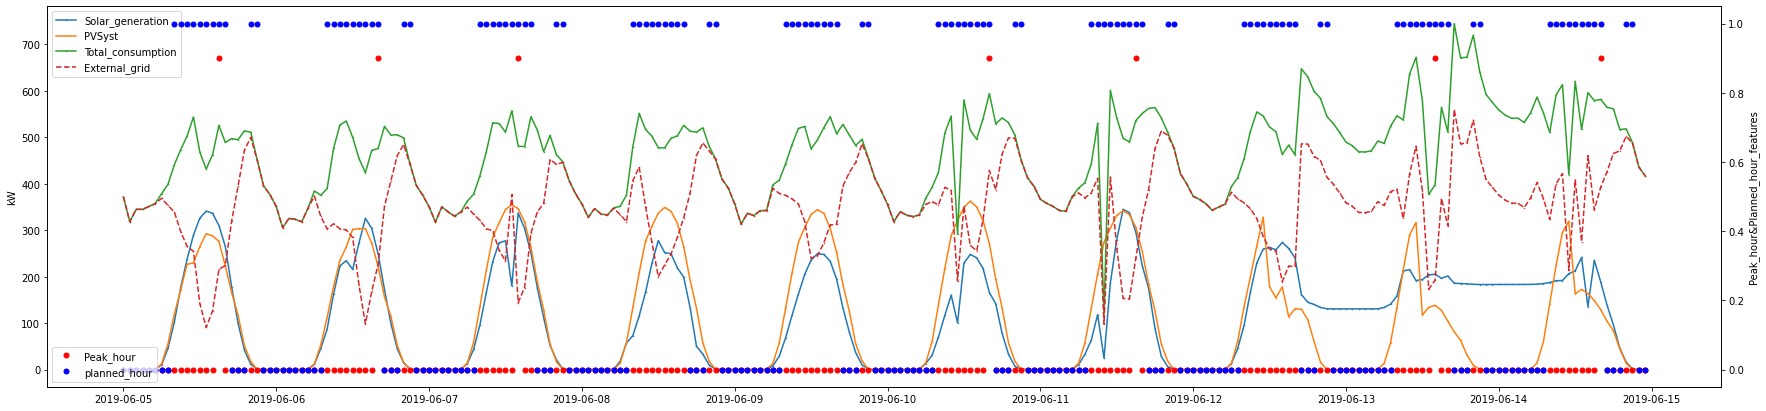

In [37]:
#на графике можно вывести измененение всех параметров включая ЧПН и ПЧПН
start, end = '2019-06-05 00:00:00', '2019-06-14 23:00:00' #вводим нужные даты для визуализации (от 2019-06-01 до 2020-12-30)
fig, ax = plt.subplots(figsize=(30, 7))
ax2 = ax.twinx()
ax.plot(dt.loc[start:end, 'Solar_generation'],
marker='.', linestyle='-', linewidth=1.5, markersize=1, label='Solar_generation')
ax.plot(dt.loc[start:end, 'PVSyst'],
marker='.', markersize=1, linewidth=1.5, linestyle='-', label='PVSyst')
ax.plot(dt.loc[start:end, 'Total_consumption'],
marker='.', markersize=1, linewidth=1.5, linestyle='-', label='Total_consumption')
ax.plot(dt.loc[start:end, 'External_grid'],
marker='.', markersize=1, linewidth=1.5, linestyle='--', label='External_grid')
ax.set_ylabel('kW') 
ax2.plot(dt.loc[start:end, 'Peak_hour']*0.9,#признак пикового часа домножен на 0,9, чтобы не сливаться с ПЧПН
color='red', label='Peak_hour',linewidth=0, marker = 'o', markersize=5)
ax2.plot(dt.loc[start:end, 'planned_hour'],
color='blue', label='planned_hour', linewidth=0, marker = 'o', markersize=5)
ax2.set_ylabel('Peak_hour&Planned_hour_features')
leg = ax.legend(loc = 2)
leg1 = ax2.legend(loc = 3)

#Красные маркеры - признак ЧПН
#Синие маркеры - признак ПЧПН

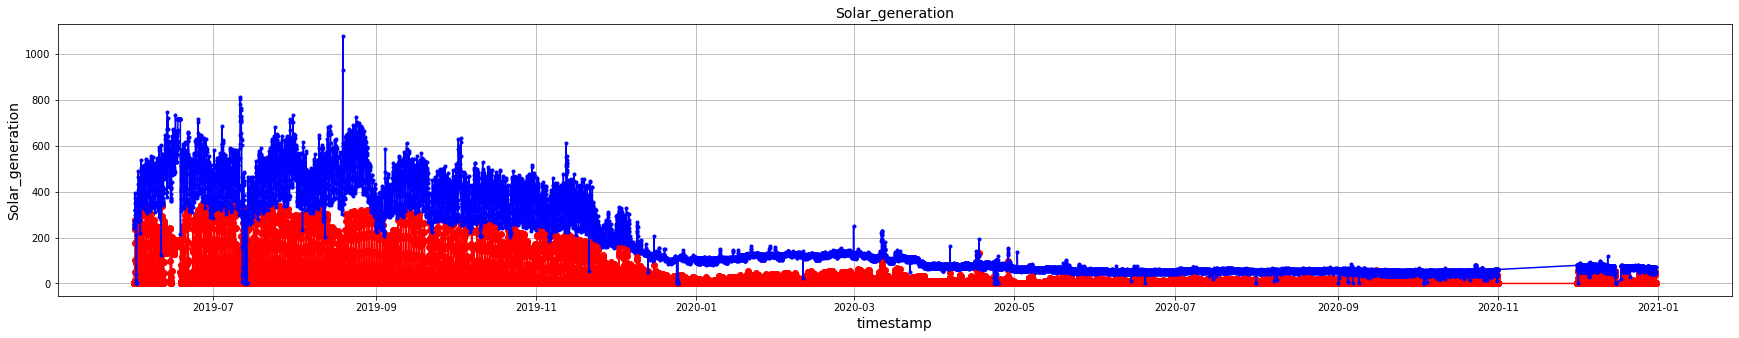

In [14]:
plt.figure(figsize=(30, 5))
plt.plot(cdf.index, cdf['Solar_generation'], color='red', marker='o')
plt.plot(cdf.index, cdf['Total_consumption'], color='blue', marker='.')
plt.title('Solar_generation', fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('Solar_generation', fontsize=14)
plt.grid(True)
plt.show()

In [157]:
#seaborn
#plt.figure(figsize=(30, 5))
#drange = dt.loc["2020-12-01 00:00:00": "2020-12-01 23:00:00"]


#fig, ax1 = plt.subplots(figsize=(20,6))
#sns.lineplot(data = drange, x=drange.index, y='Solar_generation', palette="Dark2", ax = ax1)
#sns.lineplot(data = drange["Total_consumption"], palette="Dark2", ax = ax1)
#sns.lineplot(data = drange, x=drange.index, y='PVSyst', palette="Dark2", ax = ax1)
#ax2 = ax1.twinx()
#sns.lineplot(data = drange, x=drange.index, y='Peak_hour', alpha=0.3, ax=ax2)
#sns.lineplot(data = drange, x=drange.index, y='planned_hour', alpha=0.3, ax=ax2)

## 5. Тестирование алгоритма

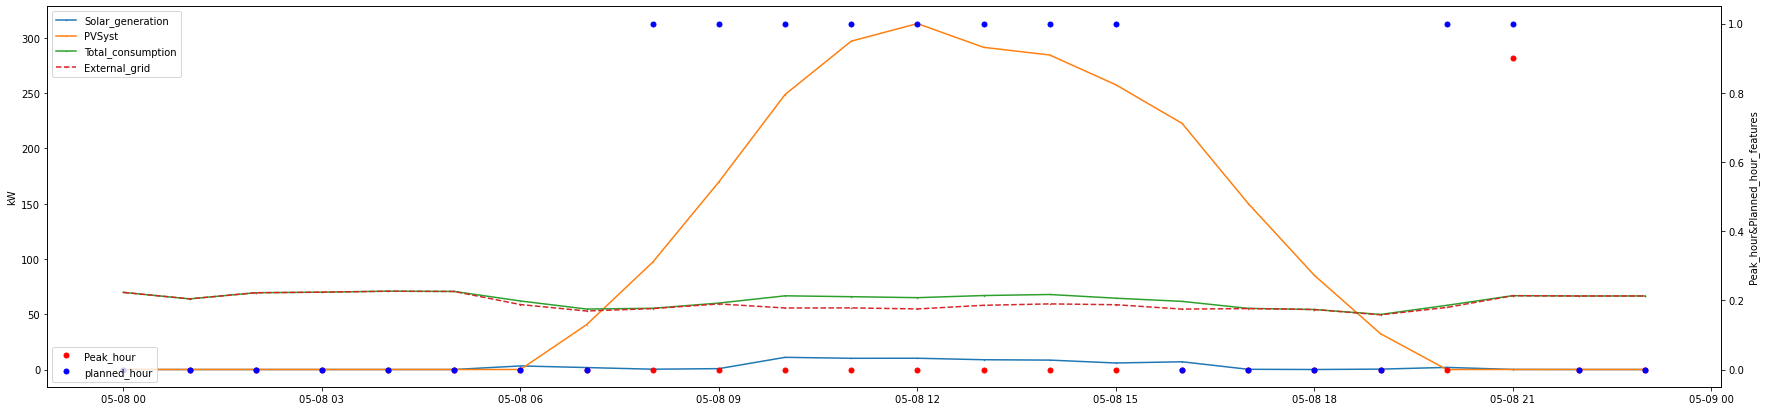

In [160]:
#выбираем тестируемый период
drange = dt.loc["2020-05-12 00:00:00": "2020-05-08 23:00:00"]
#строим график
fig, ax = plt.subplots(figsize=(30, 7))
ax2 = ax.twinx()
ax.plot(drange['Solar_generation'],
marker='.', linestyle='-', linewidth=1.5, markersize=1, label='Solar_generation')
ax.plot(drange['PVSyst'],
marker='.', markersize=1, linewidth=1.5, linestyle='-', label='PVSyst')
ax.plot(drange['Total_consumption'],
marker='.', markersize=1, linewidth=1.5, linestyle='-', label='Total_consumption')
ax.plot(drange['External_grid'],
marker='.', markersize=1, linewidth=1.5, linestyle='--', label='External_grid')
ax.set_ylabel('kW') 
ax2.plot(drange['Peak_hour']*0.9,#признак пикового часа домножен на 0,9, чтобы не сливаться с ПЧПН
color='red', label='Peak_hour',linewidth=0, marker = 'o', markersize=5)
ax2.plot(drange['planned_hour'],
color='blue', label='planned_hour', linewidth=0, marker = 'o', markersize=5)
ax2.set_ylabel('Peak_hour&Planned_hour_features')
leg = ax.legend(loc = 2)
leg1 = ax2.legend(loc = 3)

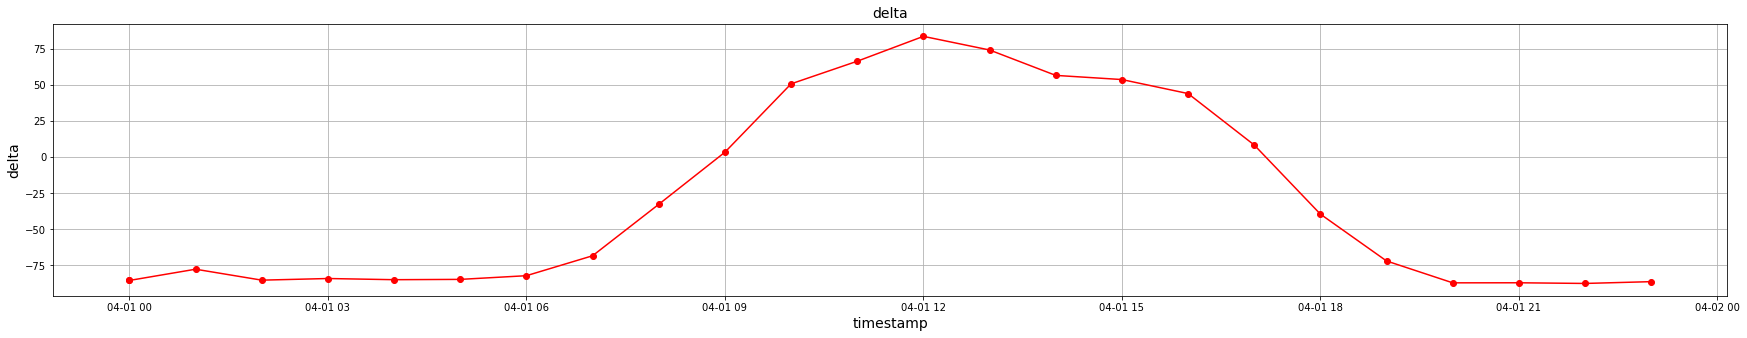

In [61]:
drange['delta']=drange['PVSyst'] - drange['Total_consumption']
plt.figure(figsize=(30, 5))
plt.plot(drange.index, drange['delta'], color='red', marker='o')
plt.title('delta', fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('delta', fontsize=14)
plt.grid(True)
plt.show()

In [57]:
drange.head(100)

,Solar_generation,External_grid,Total_consumption,PVSyst,Peak_hour,year,month,day,hour,planned_hour,delta
timestamp,,,,,,,,,,,
2020-03-01 00:00:00,0.0,131.883530,131.883530,0.0,0.0,2020,3,1,0,0.0,-131.883530
2020-03-01 00:00:00,0.0,131.883530,131.883530,0.0,0.0,2020,3,1,0,0.0,-131.883530
2020-03-01 01:00:00,0.0,119.458900,119.458900,0.0,0.0,2020,3,1,1,0.0,-119.458900
2020-03-01 02:00:00,0.0,131.487762,131.487762,0.0,0.0,2020,3,1,2,0.0,-131.487762
2020-03-01 03:00:00,0.0,130.882187,130.882187,0.0,0.0,2020,3,1,3,0.0,-130.882187
...,...,...,...,...,...,...,...,...,...,...,...
2020-03-04 22:00:00,0.0,130.131912,130.131912,0.0,0.0,2020,3,4,22,0.0,-130.131912
2020-03-04 23:00:00,0.0,128.608780,128.608780,0.0,0.0,2020,3,4,23,0.0,-128.608780
2020-03-05 00:00:00,0.0,130.042557,130.042557,0.0,0.0,2020,3,5,0,0.0,-130.042557


In [156]:
#e_current = 314 #заряд накопителя
algorithm=drange.reset_index(drop=True) #сбрасываем индекс для удобства
algorithm.loc[:, "EESS"]=0 #стартовый заряд накопителя
algorithm.loc[0, "EESS"]=155 #стартовый заряд накопителя
for i in range(len(algorithm)):
    if i>0:
        if (algorithm.loc[i, "delta"]>= 3) & (algorithm.loc[i-1, "EESS"]<314) :
            algorithm.loc[i, "EESS"] = algorithm.loc[i-1, "EESS"] + algorithm.loc[i, "delta"]/2
        else:
            algorithm.loc[i, "EESS"] = algorithm.loc[i-1, "EESS"]

        
        
algorithm

,Solar_generation,External_grid,Total_consumption,PVSyst,Peak_hour,year,month,day,hour,planned_hour,delta,EESS
0,0.000000,85.386276,85.386276,0.00000,0.0,2020,4,1,0,0.0,-85.386276,155.000000
1,0.000000,85.386276,85.386276,0.00000,0.0,2020,4,1,0,0.0,-85.386276,155.000000
2,0.000000,77.601967,77.601967,0.00000,0.0,2020,4,1,1,0.0,-77.601967,155.000000
3,0.000000,85.184319,85.184319,0.00000,0.0,2020,4,1,2,0.0,-85.184319,155.000000
4,0.000000,84.049667,84.049667,0.00000,0.0,2020,4,1,3,0.0,-84.049667,155.000000
5,0.000000,84.866348,84.866348,0.00000,0.0,2020,4,1,4,0.0,-84.866348,155.000000
6,0.000000,84.650200,84.650200,0.00000,0.0,2020,4,1,5,0.0,-84.650200,155.000000
7,0.000000,82.094437,82.094437,0.00000,0.0,2020,4,1,6,0.0,-82.094437,155.000000
8,8.278341,59.997604,68.275948,0.00000,0.0,2020,4,1,7,0.0,-68.275948,155.000000
9,10.759330,55.388229,66.147560,33.52506,0.0,2020,4,1,8,1.0,-32.622500,155.000000


In [ ]:


drange

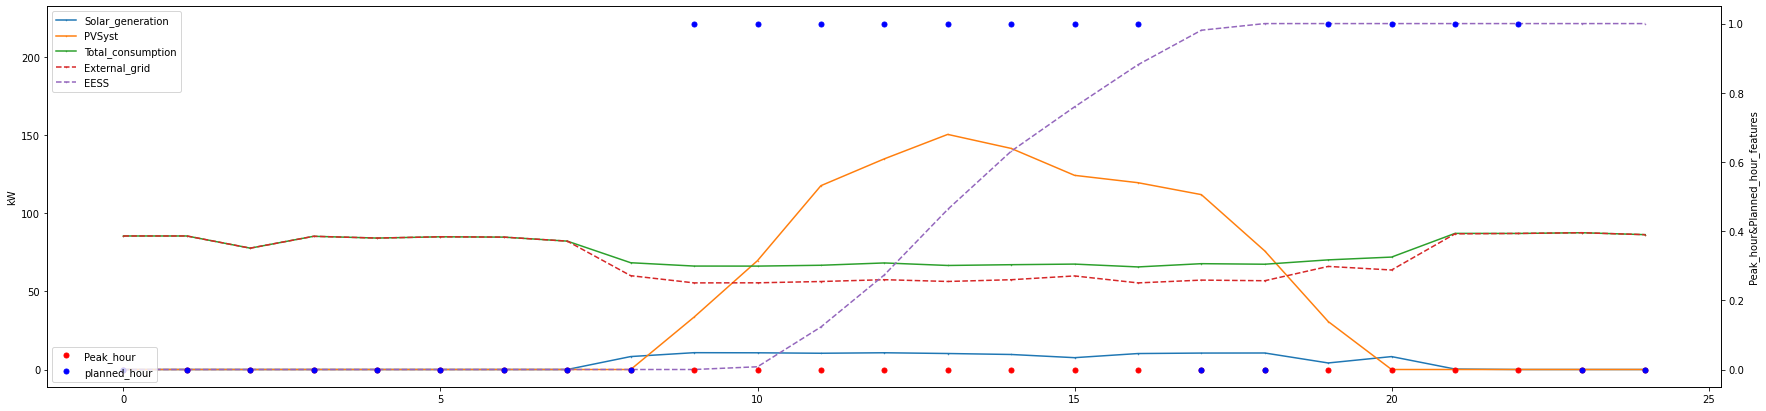

In [149]:
#строим график
fig, ax = plt.subplots(figsize=(30, 7))
ax2 = ax.twinx()
ax.plot(algorithm['Solar_generation'],
marker='.', linestyle='-', linewidth=1.5, markersize=1, label='Solar_generation')
ax.plot(algorithm['PVSyst'],
marker='.', markersize=1, linewidth=1.5, linestyle='-', label='PVSyst')
ax.plot(algorithm['Total_consumption'],
marker='.', markersize=1, linewidth=1.5, linestyle='-', label='Total_consumption')
ax.plot(algorithm['External_grid'],
marker='.', markersize=1, linewidth=1.5, linestyle='--', label='External_grid')
ax.plot(algorithm['EESS'],
marker='.', markersize=1, linewidth=1.5, linestyle='--', label='EESS')
ax.set_ylabel('kW') 
ax2.plot(algorithm['Peak_hour']*0.9,#признак пикового часа домножен на 0,9, чтобы не сливаться с ПЧПН
color='red', label='Peak_hour',linewidth=0, marker = 'o', markersize=5)
ax2.plot(algorithm['planned_hour'],
color='blue', label='planned_hour', linewidth=0, marker = 'o', markersize=5)
ax2.set_ylabel('Peak_hour&Planned_hour_features')
leg = ax.legend(loc = 2)
leg1 = ax2.legend(loc = 3)